# くずし字アノテーションの可視化

このノートブックでは、以下の可視化を行います：
1. 元の画像と文字のバウンディングボックス
2. 検出された行の領域
3. 切り出された行画像と文字のバウンディングボックス

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

In [24]:
def draw_boxes_on_image(image_path: str, coord_file: str, show_unicode: bool = False):
    """画像に文字のバウンディングボックスを描画
    
    Args:
        image_path (str): 画像ファイルのパス
        coord_file (str): 座標ファイルのパス
        show_unicode (bool, optional): Unicode文字を表示するかどうか. Defaults to True.
    """
    # 画像の読み込み
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    
    # 座標データの読み込み
    df = pd.read_csv(coord_file)
    
    # フォントの設定（Unicodeを表示する場合）
    if show_unicode:
        try:
            font = ImageFont.truetype('/usr/share/fonts/truetype/fonts-japanese-gothic.ttf', 20)
        except:
            font = ImageFont.load_default()
    
    # バウンディングボックスの描画
    print(image_path)
    for _, row in df.iterrows():
        if image_path.split("/")[-1].split(".")[0] == row['Image']:
            x1, y1 = row['X'], row['Y']
            x2, y2 = x1 + row['Width'], y1 + row['Height']
            
            # ボックスの描画
            draw.rectangle([x1, y1, x2, y2], outline='red', width=2)
            
            # Unicode文字の描画
            if show_unicode:
                draw.text((x1, y1 - 20), chr(int(row['Unicode'], 16)), font=font, fill='blue')
    
    # 画像の表示
    plt.figure(figsize=(20, 20))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [25]:
def draw_detected_lines(image_path: str, line_info_file: str):
    """検出された行の領域を可視化
    
    Args:
        image_path (str): 画像ファイルのパス
        line_info_file (str): 行情報のCSVファイルのパス
    """
    # 画像の読み込み
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    
    # 行情報の読み込み
    df = pd.read_csv(line_info_file)
    
    # この画像に関連する行情報のみを抽出
    image_lines = df[df['original_image'] == image_path]
    
    # 行の領域を描画
    colors = ['red', 'blue', 'green', 'yellow', 'purple']  # 行ごとに異なる色を使用
    for i, row in image_lines.iterrows():
        box = eval(row['box'])
        color = colors[i % len(colors)]
        draw.rectangle(box, outline=color, width=3)
    
    # 画像の表示
    plt.figure(figsize=(20, 20))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [26]:
def visualize_line_images(line_info_file: str, show_unicode: bool = False):
    """切り出された行画像と文字のバウンディングボックスを可視化
    
    Args:
        line_info_file (str): 行情報のCSVファイルのパス
        show_unicode (bool, optional): Unicode文字を表示するかどうか. Defaults to True.
    """
    # 行情報の読み込み
    df = pd.read_csv(line_info_file)
    
    # フォントの設定
    if show_unicode:
        try:
            font = ImageFont.truetype('/usr/share/fonts/truetype/fonts-japanese-gothic.ttf', 20)
        except:
            font = ImageFont.load_default()
    
    # 各行画像の処理
    for i, row in df.iterrows():
        # 行画像の読み込み
        line_image = Image.open(row['line_image'])
        draw = ImageDraw.Draw(line_image)
        
        # 文字のバウンディングボックスを描画
        char_boxes = eval(row['char_boxes'])
        unicode_ids = eval(row['unicode_ids'])
        
        for box, unicode_id in zip(char_boxes, unicode_ids):
            x1, y1, x2, y2 = box
            draw.rectangle([x1, y1, x2, y2], outline='red', width=2)
            
            if show_unicode:
                draw.text((x1, y1 - 20), chr(int(unicode_id, 16)), font=font, fill='blue')
        
        # 画像の表示
        plt.figure(figsize=(20, 5))
        plt.imshow(line_image)
        plt.title(f'Line {i+1}')
        plt.axis('off')
        plt.show()

## 1. サンプル画像の可視化

Original image with character bounding boxes:
../data/raw/dataset/100249476/images/100249476_00022_2.jpg


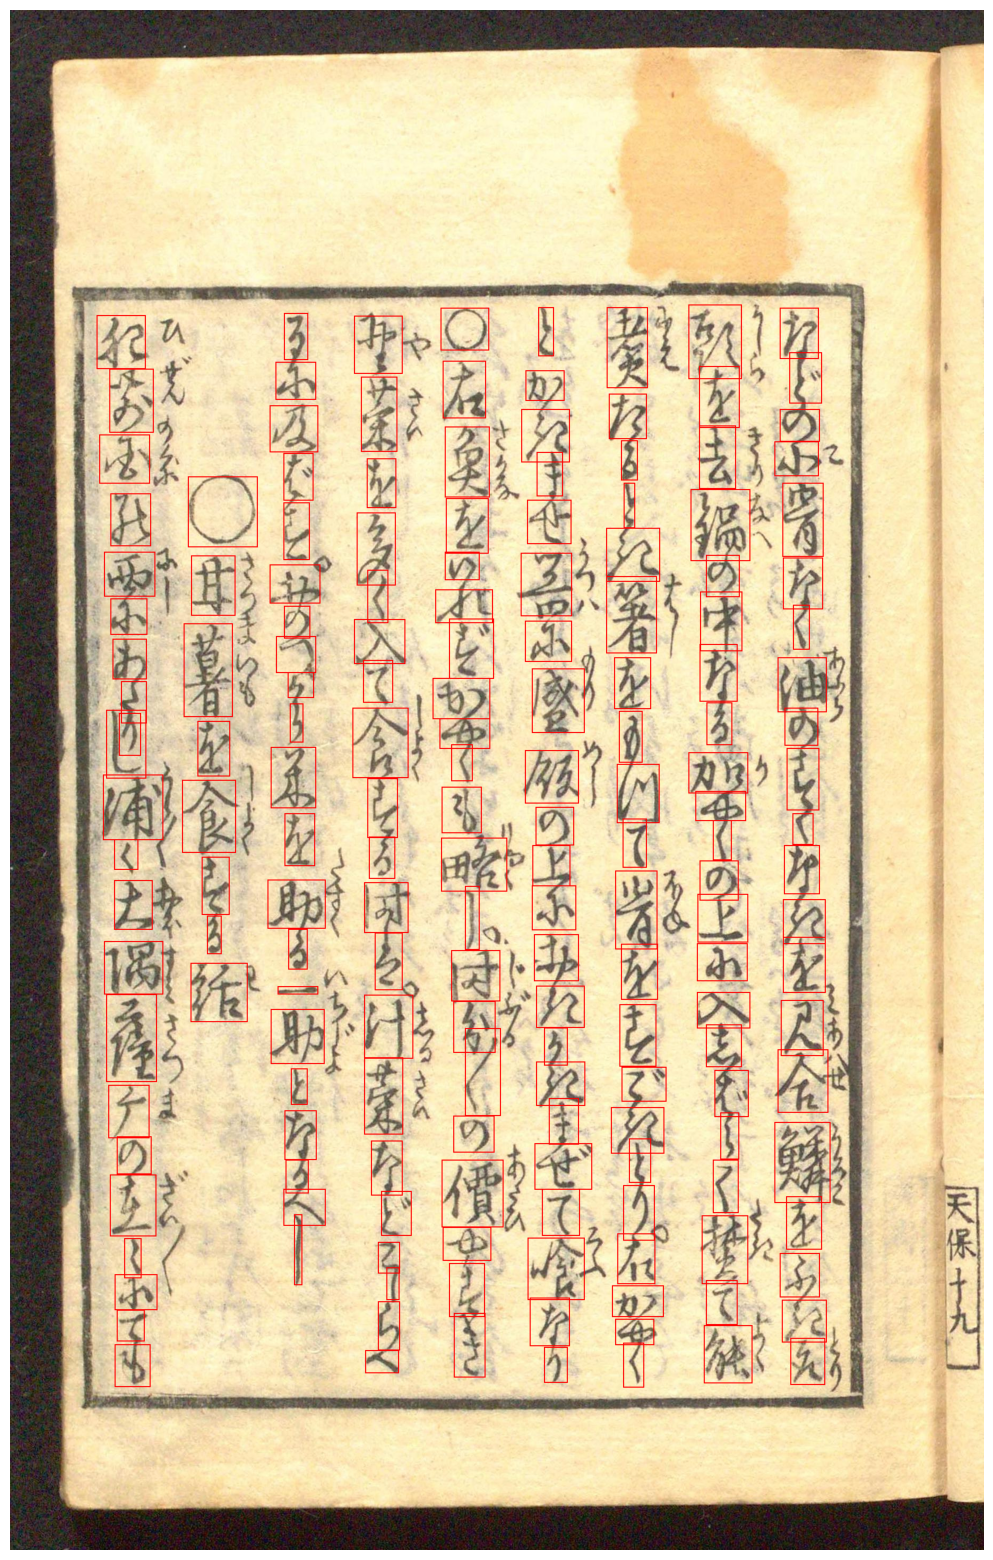

In [27]:
# サンプル画像のパスを設定
data_dir = Path('../data/raw/dataset')
sample_page_dir = next(data_dir.iterdir())  # 最初のページディレクトリを使用

# 画像とアノテーションファイルのパスを取得
images_dir = sample_page_dir / 'images'
sample_image = next(images_dir.glob('*.jpg'))  # 最初の画像を使用
coord_file = sample_page_dir / f'{sample_page_dir.name}_coordinate.csv'

# 元の画像と文字のバウンディングボックスを表示
print('Original image with character bounding boxes:')
draw_boxes_on_image(str(sample_image), str(coord_file))

## 2. 検出された行の可視化

In [ ]:
# 行情報ファイルのパス
line_info_file = 'data/processed/line_info.csv'

# 検出された行の領域を表示
print('Detected text lines:')
draw_detected_lines(str(sample_image), line_info_file)

## 3. 切り出された行画像の可視化

In [ ]:
# 切り出された行画像と文字のバウンディングボックスを表示
print('Extracted line images with character bounding boxes:')
visualize_line_images(line_info_file)